<a href="https://colab.research.google.com/github/birulboy/estructura_de_datos/blob/master/Neural_Networks_Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

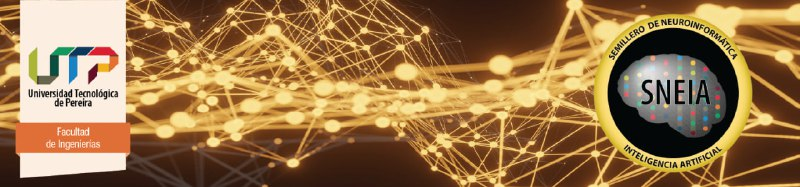

# Redes neuronales - Neural Networks

Las redes neuronales son modelos computacionales inspirados en el funcionamiento del cerebro humano, diseñados para reconocer patrones y aprender de los datos. Están compuestas por capas de neuronas artificiales (nodos) interconectadas que procesan información mediante operaciones matemáticas. Estas capas suelen incluir:

- Capa de entrada: Recibe los datos iniciales.

- Capas ocultas: Transforman los datos mediante pesos ajustables y funciones de activación.

- Capa de salida: Genera el resultado final (predicción, clasificación, etc.).

## ¿Por qué son importantes?

Las redes neuronales son la base del deep learning y han revolucionado campos como:

- Visión por computadora (reconocimiento de imágenes).

- Procesamiento de lenguaje natural (traducción, chatbots).

- Sistemas de recomendación (Netflix, Amazon).

- Automatización industrial y medicina (diagnósticos predictivos).

Su capacidad para aprender relaciones complejas en grandes volúmenes de datos las hace indispensables en la era de la inteligencia artificial.

## ¿Cómo funcionan?

- Propagación hacia adelante (forward propagation): Los datos fluyen desde la entrada hasta la salida, transformándose en cada capa.

- Función de activación: Introduce no linealidad (ej: ReLU, sigmoide) para modelar relaciones complejas.

- Cálculo de pérdida: Mide el error entre la predicción y el valor real.

- Retropropagación (backpropagation): Ajusta los pesos de la red utilizando algoritmos de optimización (ej: descenso de gradiente) para minimizar el error.

- Iteración: Repite el proceso hasta que el modelo "aprende".

## ¿Qué aprenderemos en este colab?

En este cuaderno colab, explorarás:

- Fundamentos teóricos: Arquitecturas básicas (perceptrón, redes densamente conectadas).

- Implementación práctica: Construcción de una red neuronal desde cero usando bibliotecas como TensorFlow/Keras o PyTorch.

- Entrenamiento y evaluación: Ajuste de hiperparámetros (tasa de aprendizaje, épocas) y métricas de desempeño (exactitud, pérdida).

# ¿Qué son las redes neuronales?

Una red neuronal en deep learning es un modelo computacional inspirado en la estructura y funcionamiento del cerebro biológico. Está compuesta por capas interconectadas de unidades llamadas neuronas artificiales, que procesan información para aprender patrones complejos a partir de datos. En el contexto del deep learning, estas redes se caracterizan por tener múltiples capas ocultas (hidden layers), lo que les permite modelar relaciones no lineales y abstraer características jerárquicas de manera automática.

El término "deep" (profundo) hace referencia al uso de múltiples capas ocultas, lo que permite a la red aprender representaciones de datos en niveles de abstracción creciente.

## Analogía con el cerebro

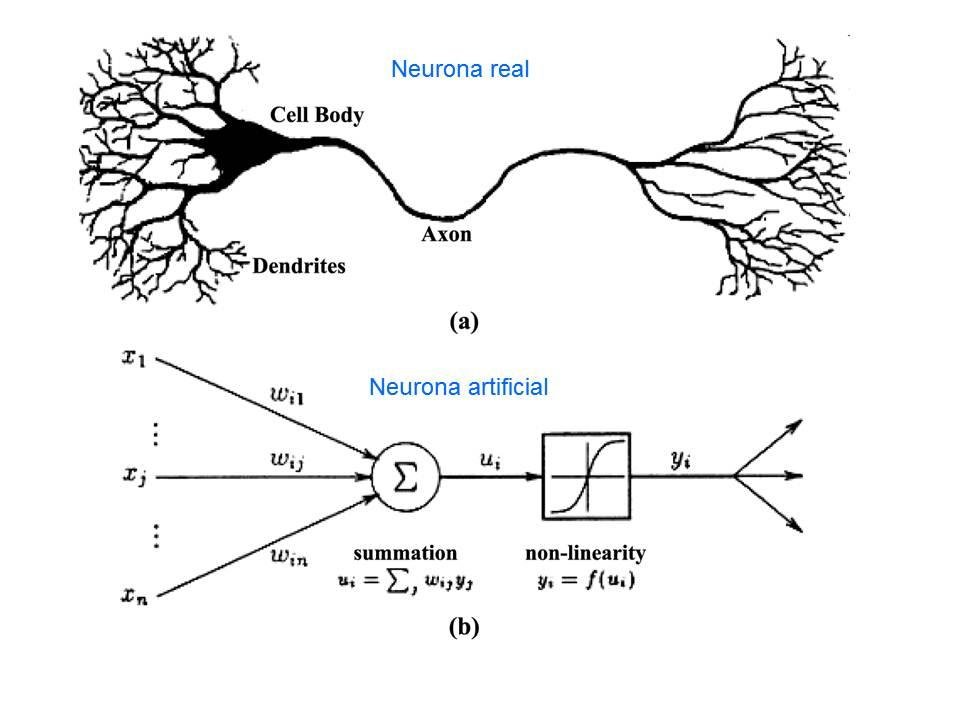

- Neuronas:
  - Las neuronas (células nerviosas) reciben señales a través de las dendritas, las procesan en el cuerpo de la célula y transmiten las salidas por el axón mediante sinapsis.
  - Las neuronas artificiales (Nodos) reciben las entradas, como las dendritas; aplican pesos y transformaciones (Funciones de activación) y producen salidas como los axónes

- Conexiones y sinapsis
  - Las sinapsis son conexiones entre neuronas, y su fuerza (plasticidad sináptica) determina cómo se transmiten las señales. El aprendizaje se produce reforzando o debilitando las sinapsis.
  - Los pesos entre neuronas artificiales imitan la fuerza sináptica. Durante el entrenamiento, los pesos se ajustan (mediante retropropagación) para optimizar el rendimiento.

- Capas y jerarquía:
  - El cerebro procesa la información mediante capas jerárquicas (por ejemplo, corteza visual: bordes → formas → objetos).

  - Las capas (entrada → oculta → salida) procesan los datos jerárquicamente:

    - Las primeras capas aprenden características simples (bordes en imágenes, tallos de palabras en texto).

    - Las capas más profundas las combinan en patrones complejos (objetos, frases).

- Aprendizaje y adaptación
  - El aprendizaje se produce a través de la neuroplasticidad: las sinapsis se adaptan en función de la experiencia (por ejemplo, «si se disparan juntas, se conectan juntas»).

  - El aprendizaje se produce a través del entrenamiento:

    - La función de pérdida mide los errores.

    - La retropropagación ajusta los pesos para minimizar el error (similar a la plasticidad sináptica).



## Componentes de una red neuronal artificial

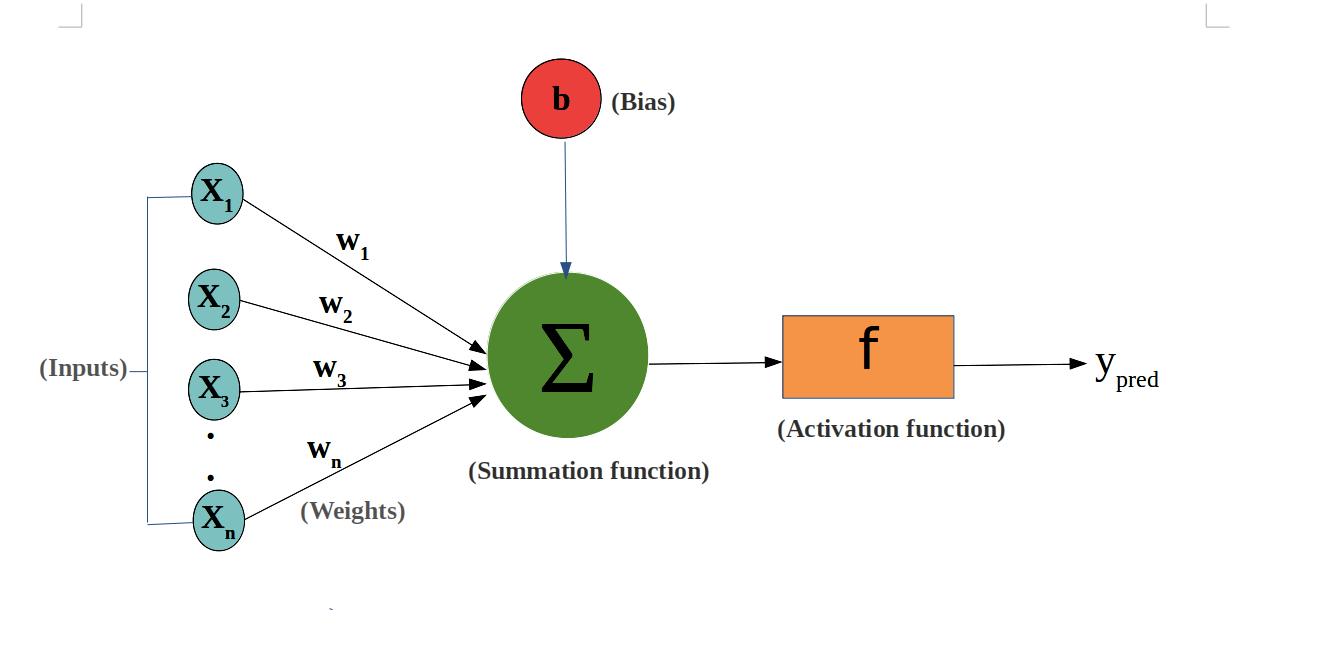

Para implementar la red neuronal utilizaremos la base de datos de EEGdenoiseNet, la cual es  un conjunto de datos de referencia, que es adecuado para entrenar y probar modelos de denoising de EEG basados en aprendizaje profundo, así como para comparar el rendimiento entre diferentes modelos. Contiene 4514 epocas de EEG limpias, 3400 epocas de EOG y 5598 epocas de EMG, lo que permite producir un gran número de épocas de EEG ruidosas con datos reales para entrenar y probar modelos.

#### Preprocesamiento de datos

Cargamos los datos utilizando la librería de numpy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

# Cargamos los datos
eog = np.load("EOG_all_epochs.npy")
eeg = np.load("EEG_all_epochs.npy")
emg = np.load("EMG_all_epochs.npy")

# Adaptamos el tamaño al de eog
eeg = eeg[:len(eog), :]
emg = emg[:len(eog), :]

In [ ]:
def plot_data(**args):
    secs = np.linspace(0, 1, 512)
    n_signals = len(args)
    plt.figure(figsize=(5 * n_signals, 5))

    for index, (name, data) in enumerate(args.items(), start=1):
        plt.subplot(1, n_signals, index)
        plt.title(name)
        plt.plot(secs, data[1, :512])
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (mV)")

    plt.tight_layout()
    plt.show()


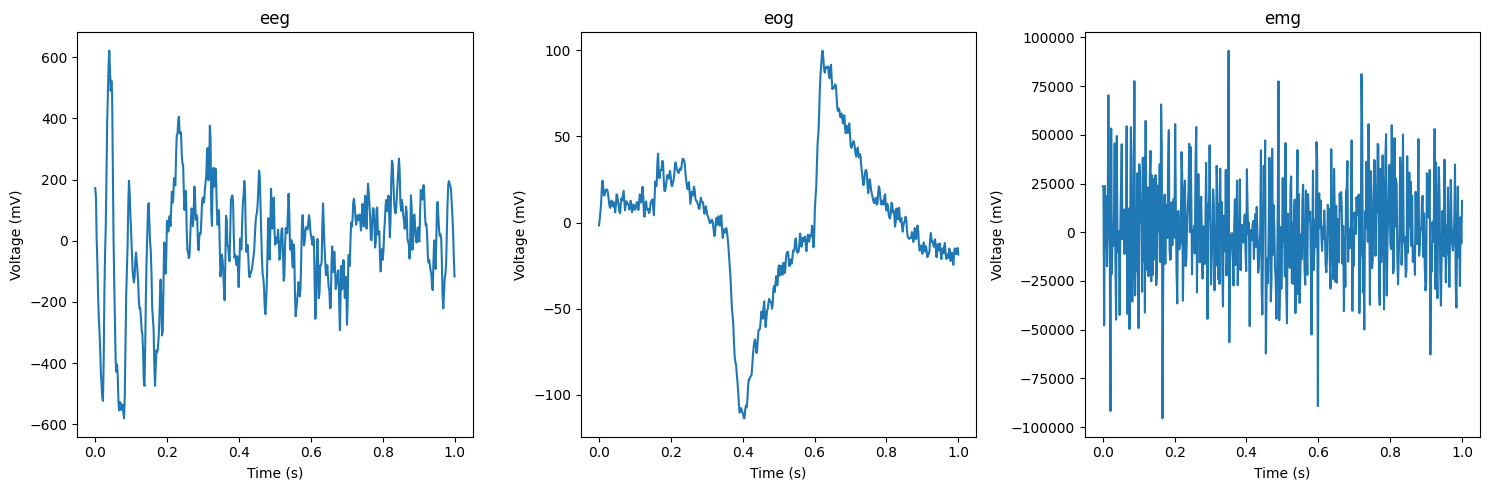

In [ ]:
plot_data(eeg=eeg, eog=eog, emg=emg)

Para crear el dataset debemos de contaminar la señal EEG con ruido de EOG Y EMG.

In [ ]:
# Generamos factores de ruido aleatorios
noise_lambda = np.random.rand(eeg.shape[0], 1)

# Inicializamos arreglos para almacenar las señales contaminadas
eog_lambda_noise = np.zeros_like(eog, dtype=float)
emg_lambda_noise = np.zeros_like(emg, dtype=float)
eeg_noise = np.zeros_like(eeg, dtype=float)

# Obtenemos las dimensiones
rows, colms = eeg.shape

# Generamos ruido aleatorio
for i in range(rows):
    eog_lambda_noise[i, :] = eog[i, :] + noise_lambda[i] * eog[i, :]

for i in range(rows):
    emg_lambda_noise[i, :] = emg[i, :] + noise_lambda[i] * emg[i, :]

# Contaminamos la señal EEG
eeg_noise = eeg + eog_lambda_noise + 0.0015*emg_lambda_noise

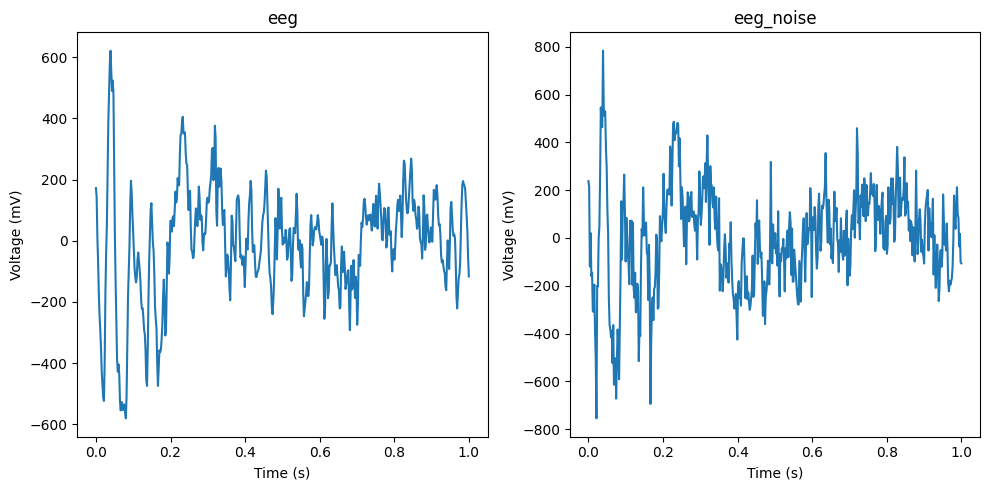

In [ ]:
plot_data(eeg=eeg, eeg_noise=eeg_noise)

El escalado de datos es crucial porque la escala de los datos afecta directamente cómo funcionan los algoritmos de Machine Learning y Deep Learning. Las razones principales para escalar los datos son:

- Evitar el predominio de características con mayor magnitud:
Algunos algoritmos (como SVM, KNN y redes neuronales) calculan distancias entre puntos o dependen de la magnitud de los datos. Si una característica tiene valores mucho mayores que las demás, dominará los cálculos y podría sesgar el modelo.

- Mejorar la convergencia en algoritmos de optimización:
En Deep Learning, las redes neuronales utilizan optimizadores (como SGD o Adam) que son sensibles a las magnitudes de los datos. Escalar las características ayuda a que los gradientes sean más consistentes y evita problemas como la divergencia durante el entrenamiento.

- Normalización de entradas para redes neuronales:
Redes neuronales son más estables y entrenan más rápido cuando las entradas están en un rango específico, por ejemplo, entre: 0 y 1 o −1 y 1.

- Estandarizar unidades:
Diferentes características pueden tener diferentes unidades (e.g., metros, kilogramos, segundos). Escalarlas garantiza que todas tengan un impacto proporcional en el modelo.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustamos y transformamos los datos limpios

eeg_clean_scaled = scaler.fit_transform(eeg)
eeg_noise_scaled = scaler.fit_transform(eeg_noise)

Ahora dividimos los datos en entrenamiento, testeo y validación.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en entrenamiento, testeo y validación

X_train, X_test, y_train, y_test = train_test_split(eeg_noise_scaled, eeg_clean_scaled, test_size=0.2, random_state=42)

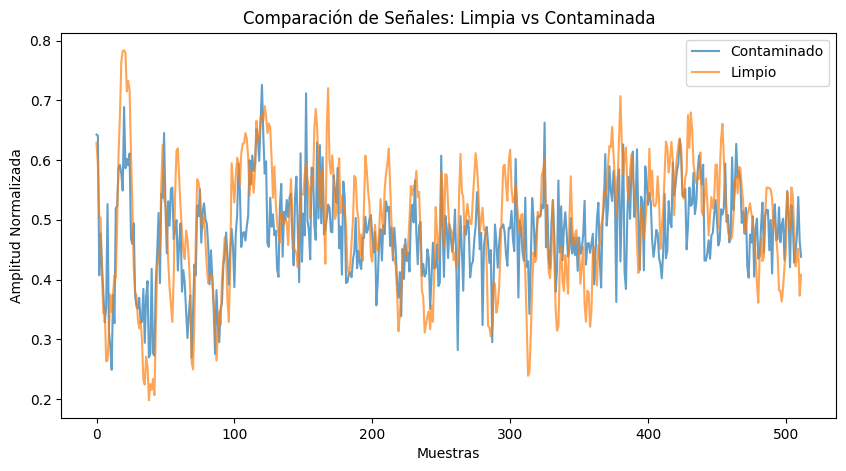

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(eeg_noise_scaled[1, :512], label='Contaminado', alpha=0.7)
plt.plot(eeg_clean_scaled[1, :512], label='Limpio', alpha=0.7)
plt.legend()
plt.title("Comparación de Señales: Limpia vs Contaminada")
plt.xlabel("Muestras")
plt.ylabel("Amplitud Normalizada")
plt.show()

### Bias

Es un valor adicional que se suma al resultado de las entradas multiplicadas por sus pesos antes de aplicar la función de activación.El bias o sesgo es entrenable.

Para trabajar con redes neuronales debemos de especificar la entrada de la red.
 A su vez debemos de declarar el tipo de red. Para eso debemos de realizar lo siguiente:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Sequential es una clase de Keras que permite construir modelos apilando capas de manera lineal, es decir, una capa después de otra.

In [ ]:
model = Sequential()

La capa Input se utiliza para definir la forma de los datos que se ingresan al modelo. En este caso, Input(shape=(input_dim,)) indica que cada muestra de entrada es un vector de longitud input_dim (por ejemplo, 10).

In [ ]:
model.add(Input(shape=(512, 1)))

### Función de suma

La función de suma (también llamada suma ponderada o combinación lineal) en una red neuronal artificial es el paso fundamental en el que una neurona combina sus entradas con los pesos asociados y agrega un sesgo (bias). Es la operación matemática que precede a la aplicación de la función de activación.

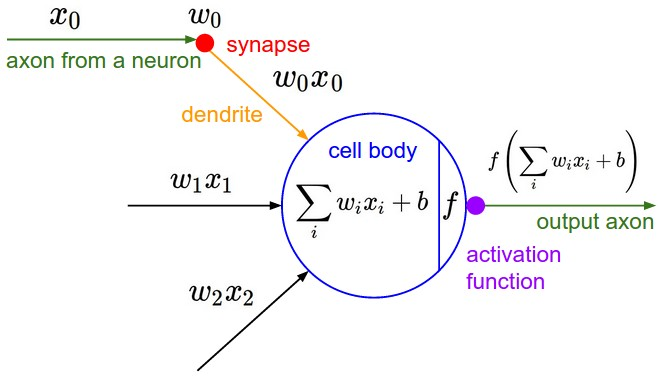

### Funciones de activación

Las funciones de activación son componentes críticos en una red neuronal, responsables de introducir no linealidad en el modelo. Sin ellas, una red neuronal sería equivalente a una combinación lineal de sus entradas, incapaz de aprender patrones complejos. Son funciones matemáticas que transforman la suma ponderada (resultado de la combinación de entradas, pesos y sesgo) en una salida no lineal. Se aplican a cada neurona en las capas ocultas y, en ocasiones, en la capa de salida.

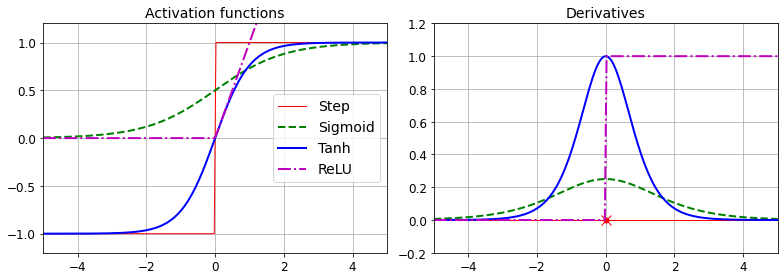

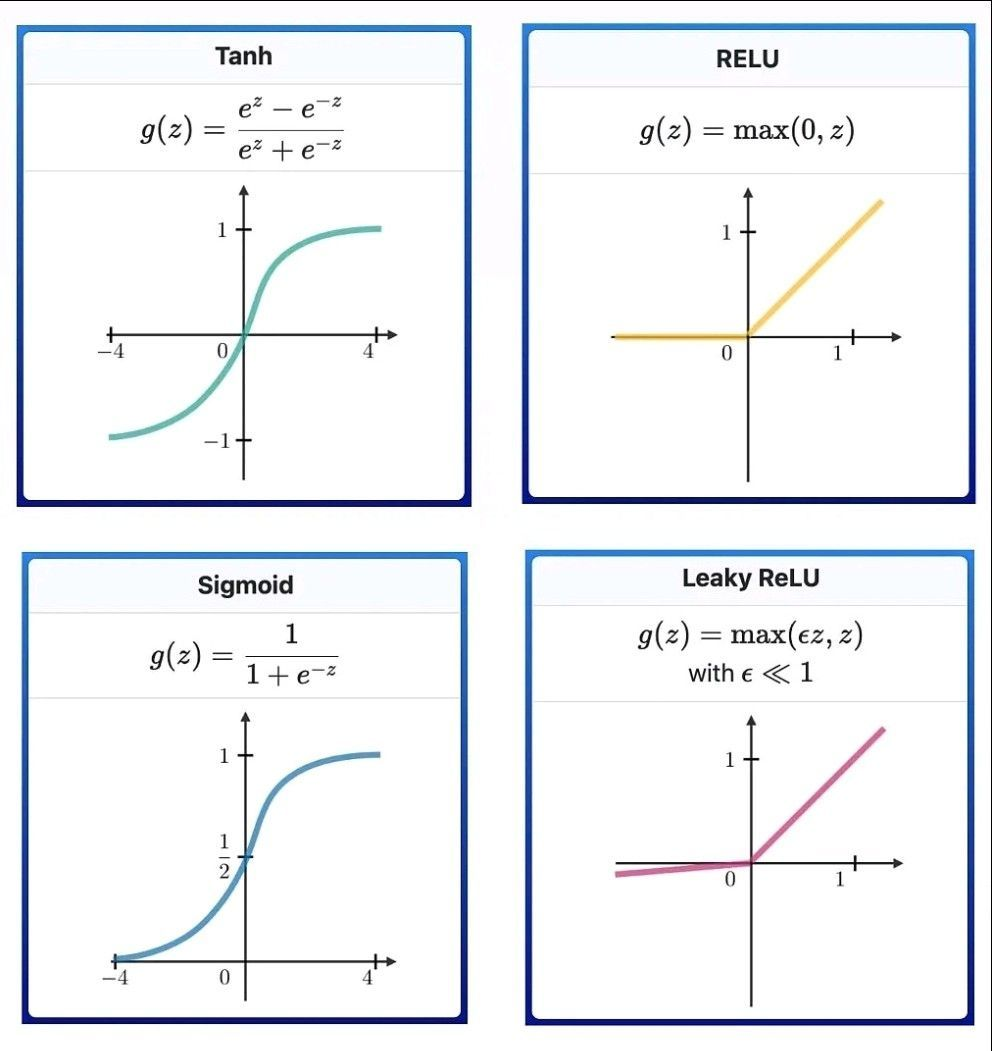

In [ ]:
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='linear'))


### Funciones de pérdida

Una función de pérdida es una métrica que cuantifica la diferencia entre las predicciones de una red neuronal y los valores reales esperados. En otras palabras, mide el error o la calidad de las predicciones del modelo.
La función de pérdida es crucial para entrenar la red, ya que proporciona una guía para ajustar los pesos y el bias a través del proceso de optimización.

**Error Cuadrático Medio (MSE - Mean Squared Error):**

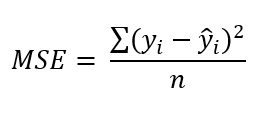

**Error Absoluto Medio (MAE - Mean Absolute Error):**

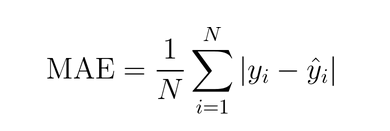

**Huber Loss:**

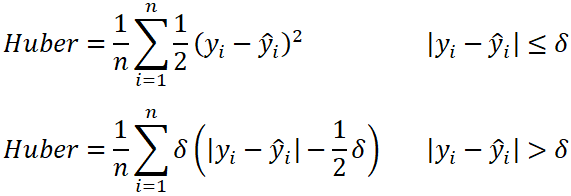

**Entropía Cruzada Binaria (Binary Cross-Entropy):**

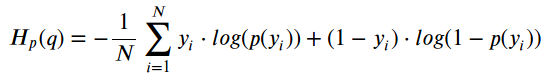

**Entropía Cruzada Categórica (Categorical Cross-Entropy):**

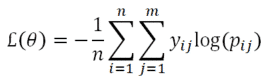

### Optimizadores

Un optimizador es un algoritmo que ajusta los pesos (w) y los sesgos (b) de una red neuronal para minimizar la función de pérdida. Es la herramienta que permite que una red neuronal aprenda al encontrar los parámetros óptimos que reducen el error en las predicciones.

Existen diferentes optimizadores, cada uno con ventajas y desventajas, según el problema que se desea resolver.

##### **Gradiente Descendente (Gradient Descent)**
   - Es el algoritmo más básico de optimización.
   - Actualiza los parámetros moviéndose en la dirección opuesta al gradiente de la función de pérdida.

- **Problemas**:
   - Puede ser lento si los gradientes son pequeños.
   - Sensible a la escala de los datos.

##### **Stochastic Gradient Descent (SGD)**:
   - En lugar de calcular el gradiente en todo el conjunto de datos, lo hace en muestras pequeñas (**minibatches**).
   - Ventajas: Rápido y eficiente para grandes conjuntos de datos.
   - Desventajas: Los pasos pueden ser inestables, ya que el gradiente estimado puede variar mucho entre minibatches.

##### **Momentum**:
   - Introduce un término que acumula gradientes pasados para suavizar las actualizaciones.

##### **AdaGrad (Adaptive Gradient)**:
   - Ajusta la tasa de aprendizaje para cada parámetro de manera individual, haciendo que disminuya con el tiempo.
   - Beneficio: Funciona bien con características de diferentes escalas.
   - Problema: La tasa de aprendizaje puede llegar a ser demasiado pequeña.

##### **RMSProp (Root Mean Square Propagation)**:
   - Modifica AdaGrad para que no disminuya excesivamente la tasa de aprendizaje.

##### **Adam (Adaptive Moment Estimation)**:
   - Combina Momentum y RMSProp para obtener las ventajas de ambos.
   - **Ventajas**:
     - Rápido, eficiente y robusto en redes profundas.
     - Escala bien con grandes cantidades de datos.




In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

model.compile(
    optimizer=Adam(learning_rate=0.001),              # Optimizador: algoritmo que ajusta los pesos durante el entrenamiento.
    loss='mse',                    # Función de pérdida: mide qué tan lejos están las predicciones de los valores reales.
    metrics=['mse', 'mae']           # Métricas: para evaluar el desempeño del modelo durante el entrenamiento y validación.
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512, 256)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512, 64)             │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512, 32)             │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512, 16)             │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512, 8)              │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512, 16)             │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512, 32)             │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512, 64)             │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512, 128)            │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512, 256)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512, 1)              │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,809 (346.91 KB)

 Trainable params: 88,809 (346.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32
)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0903 - mae: 0.2333 - mse: 0.0903
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - mae: 0.0831 - mse: 0.0113
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - mae: 0.0816 - mse: 0.0108
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107 - mae: 0.0813 - mse: 0.0107
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - mae: 0.0815 - mse: 0.0108
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - mae: 0.0816 - mse: 0.0108
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0106 - mae: 0.0808 - mse: 0.0106
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0106 - mae: 0.0808 - mse: 0.0106
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - mae: 0.0814 - mse: 0.0108
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107 - mae: 0.0811 - mse: 0.0107
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss:

In [ ]:
y_predicted = model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:
r2_score = r2_score(X_test[1,:], y_predicted[1,:])
mse = mean_squared_error(X_test[1,:], y_predicted[1,:])
mae = mean_absolute_error(X_test[1,:], y_predicted[1,:])

print(r2_score)
print(mae)
print(mse)

0.8078319477362635
0.023389629775921527
0.00076609018866196


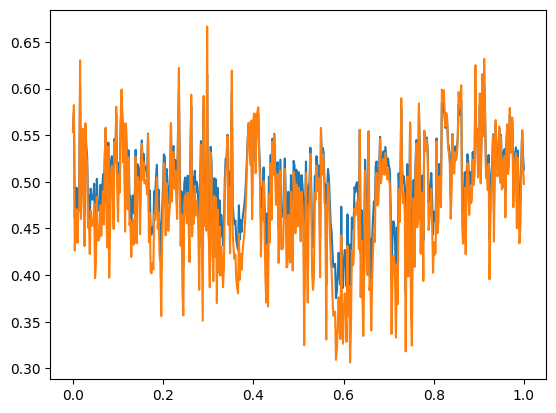

In [ ]:
secs = np.linspace(0, 1, 512)
plt.plot(secs, y_predicted[1, :])
plt.plot(secs, X_test[1, :])
plt.show()